## 순환 신경망 (Recurrent Neural Network, RNN)
* 시퀀스 데이터를 예측하기 위해 만들어진 모델로 시계열 예측 기술의 근간이라고 할 수 있다.
* 기본적인 인공 신경망은 입력값 하나가 들어오면 출력값 하나를 산출하며 이전 입력값과 다음 입력값의 관계는 고려하지 않는다.
* 이를 개선하기 위해 이전 단계에서 계산된 정보를 가공해서 다음 단계의 계산에 반영하는 것이 순환 신경망이다.
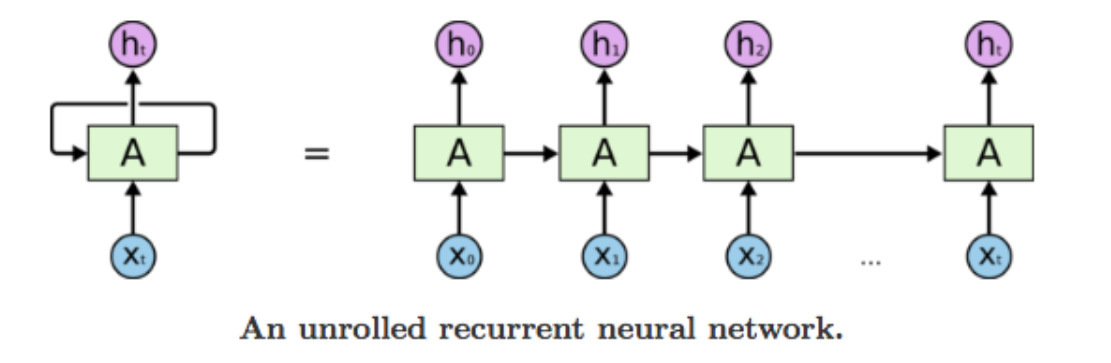

### 기본 순환 신경망 구현

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/data/kospi.csv")
# MinMaxScaler는 모든 특성이 0과 1 사이에 위치하도록 데이터를 변경하는 방법을 제공한다.
scaler = MinMaxScaler()
# 'Open', 'High', 'Low', 'Close', 'Volume' 열의 데이터를 MinMaxScaler를 사용하여 정규화하고,
# 정규화된 데이터로 해당 열을 업데이트한다,
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


### 텐서 데이터 만들기
* 사용할 데이터는 인스턴스가 413개이고 피처가 4개(Open, High, Low, Volume)이고 타깃값은 종가(Close)이다.
* 즉, 431x4 시계열 데이터를 가지고 있다.
* 이 단계에서 고려해야 할 점은 며칠을 사용하여 다음 날 종가를 예측하느냐는 것과 학습 데이터와 평가 데이터의 비율이다.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [14]:
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  # x에서 sequence_length만큼의 데이터를 잘라내어 x_seq에 추가한다.
  # y에서 sequence_length 다음 데이터를 y_seq에 추가한다.
  # 이렇게 하면 sequence_length 길이의 연속적인 입력 데이터와 그 다음의 레이블을 생성한다.
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i:i + sequence_length])
    y_seq.append(y[i + sequence_length])
  # 생성된 시퀀스 데이터를 PyTorch의 FloatTensor로 변환하고, GPU에 올린 후 반환한다.
  # view(-1,1)는 y_seq의 형태를 [배치 크기, 1]로 바꾸는 역할을 한다.
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [16]:
# 이 부분은 데이터를 분리할 지점을 설정한다.
# 200번째 데이터를 기점으로 앞 부분은 훈련 데이터, 뒷 부분은 테스트 데이터로 사용할 예정이다.
split=200
# 시퀀스의 길이를 설정한다.
sequence_length=5
# seq_data 함수를 사용하여 입력 데이터 X와 레이블 y를 시퀀스 데이터로 변환한다.
x_seq, y_seq=seq_data(X,y,sequence_length)
# 시퀀스 데이터를 split 지점까지 슬라이싱하여 훈련 데이터를 생성한다.
x_train_seq=x_seq[:split]
y_train_seq=y_seq[:split]
# split 지점 이후의 시퀀스 데이터를 슬라이싱하여 테스트 데이터를 생성한다.
x_test_seq=x_seq[split:]
y_test_seq=y_seq[split:]

# 훈련 데이터와 테스트 데이터의 크기를 출력한다.
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [19]:
# TensorDataset은 텐서를 입력으로 받아 데이터셋을 생성하는 클래스이다.
# 이 코드는 훈련 데이터 x_train_seq와 y_train_seq를 TensorDataset으로 묶어 train 데이터셋을 생성한다.
train=torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
# 테스트 데이터 x_test_seq와 y_test_seq를 TensorDataset으로 묶어 test 데이터셋을 생성한다.
test=torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
# DataLoader에서 한 번에 로드할 데이터의 개수는 20이다.
batch_size=20
# DataLoader는 dataset과 batch_size를 입력으로 받아 데이터를 배치 단위로 로드하는 반복자를 생성한다.
# shuffle=True는 데이터를 섞어서 로드하도록 설정한다.
# train 데이터셋을 배치 단위로 로드하는 train_loader를 생성한다.
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
# test 데이터셋을 배치 단위로 로드하는 test_loader를 생성한다.
test_loader=torch.utils.data.DataLoader(dataset=test,batch_size=batch_size)

### RNN 구축에 필요한 하이퍼 파라미터 정의하기
* RNN의 연산은 파이토치에서 제공하기 때문에 전체를 직접 구현하지 않아도 된다.
* 우리가 정해야 하는 것은 (1) 입력 변수의 개수, (2) 은닉층의 개수, (3) 은닉 상태를 저장하는 벡터 크기다.

In [20]:
input_size=x_seq.size(2)
num_layers=2
hidden_size=8

### RNN 구축하기


In [25]:
class VanillaRNN(nn.Module):
  # VanillaRNN 클래스의 생성자를 정의한다.
  # 이 생성자는 모델의 파라미터를 초기화한다.
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN,self).__init__()
    self.device=device
    self.hidden_size=hidden_size # RNN 층의 개수를 정의한다.
    self.num_layers=num_layers # RNN 층의 개수를 정의한다.
    self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True) # nn.RNN 모듈을 사용하여 RNN 층을 정의한다.
    self.fc=nn.Sequential(nn.Linear(hidden_size*sequence_length,1),nn.Sigmoid())
    # nn.Sequential을 사용하여 완전 연결 층(Linear layer)과 시그모이드 활성화 함수를 연결한다.
    # 이 층은 RNN의 출력을 입력으로 받아 이진 분류 결과를 출력한다.

  def forward(self, x): # forward 메소드는 모델이 학습 데이터를 어떻게 처리할지를 정의한다.
    h0=torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device) # 은닉 상태를 초기화한다.
    out,_=self.rnn(x,h0) # RNN 층을 통과시킨다.
    out=out.reshape(out.shape[0],-1) # 출력 텐서의 형태를 변경한다.
    out=self.fc(out) # 완전 연결 층을 통과시킨다.
    return out

### RNN 모델 불러오기
* 입력값의 크기, 은닉 상태 크기, 시퀀스 길이, 은닉층 개수, gpu 연산을 위한 device 변수까지 모델에 넣어준다.
* 또한 GPU 연산을 위해 .to(device)를 붙여준다.

In [26]:
model=VanillaRNN(input_size=input_size,
                 hidden_size=hidden_size,
                 sequence_length=sequence_length,
                 num_layers=num_layers,
                 device=device).to(device)

### 손실 함수 및 최적화 방법 정의
* 주가를 예측하는 것이므로 회귀문제다.
* 따라서 대표적인 MSE 손실 함수를 사용한다.
* 학습은 301회이고 최적화 방법은 Adam을 사용한다.

In [28]:
criterion=nn.MSELoss()
num_epochs=301
optimizer=optim.Adam(model.parameters(),lr=1e-3)

### 모델 학습하기

In [29]:
loss_graph=[]
n=len(train_loader)

for epoch in range(num_epochs):
  running_loss=0.0 # 각 에포크마다 손실 값을 0으로 초기화한다.

  for data in train_loader:
    seq,target=data # 배치 데이터를 입력 데이터(seq)와 레이블(target)로 분리한다.
    out=model(seq) # 모델에 입력 데이터를 전달하여 출력 값을 계산한다.
    loss=criterion(out,target) #  손실 함수를 사용하여 모델의 예측과 실제 값 사이의 손실을 계산한다.

    optimizer.zero_grad() # 역전파 단계를 실행하기 전에 기존의 그래디언트를 0으로 만든다.
    loss.backward() # 손실에 대해 역전파를 수행하여 그래디언트를 계산한다.
    optimizer.step() # 계산된 그래디언트를 사용하여 옵티마이저를 통해 모델의 파라미터를 업데이트한다.
    running_loss+=loss.item() # 현재 배치의 손실을 총 손실에 더한다.

  loss_graph.append(running_loss/n) # 평균 손실을 loss_graph에 추가한다.

  if epoch%100==0: # 100 에포크마다 손실을 출력한다.
    print('[epoch: %d] loss: %.4f' %(epoch,running_loss/n))

[epoch: 0] loss: 0.0200
[epoch: 100] loss: 0.0007
[epoch: 200] loss: 0.0005
[epoch: 300] loss: 0.0004


### 학습 손실 함수값 그리기
* 손실 함수를 통해 단편적으로 훈련이 잘 됐음을 확인할 수 있다.

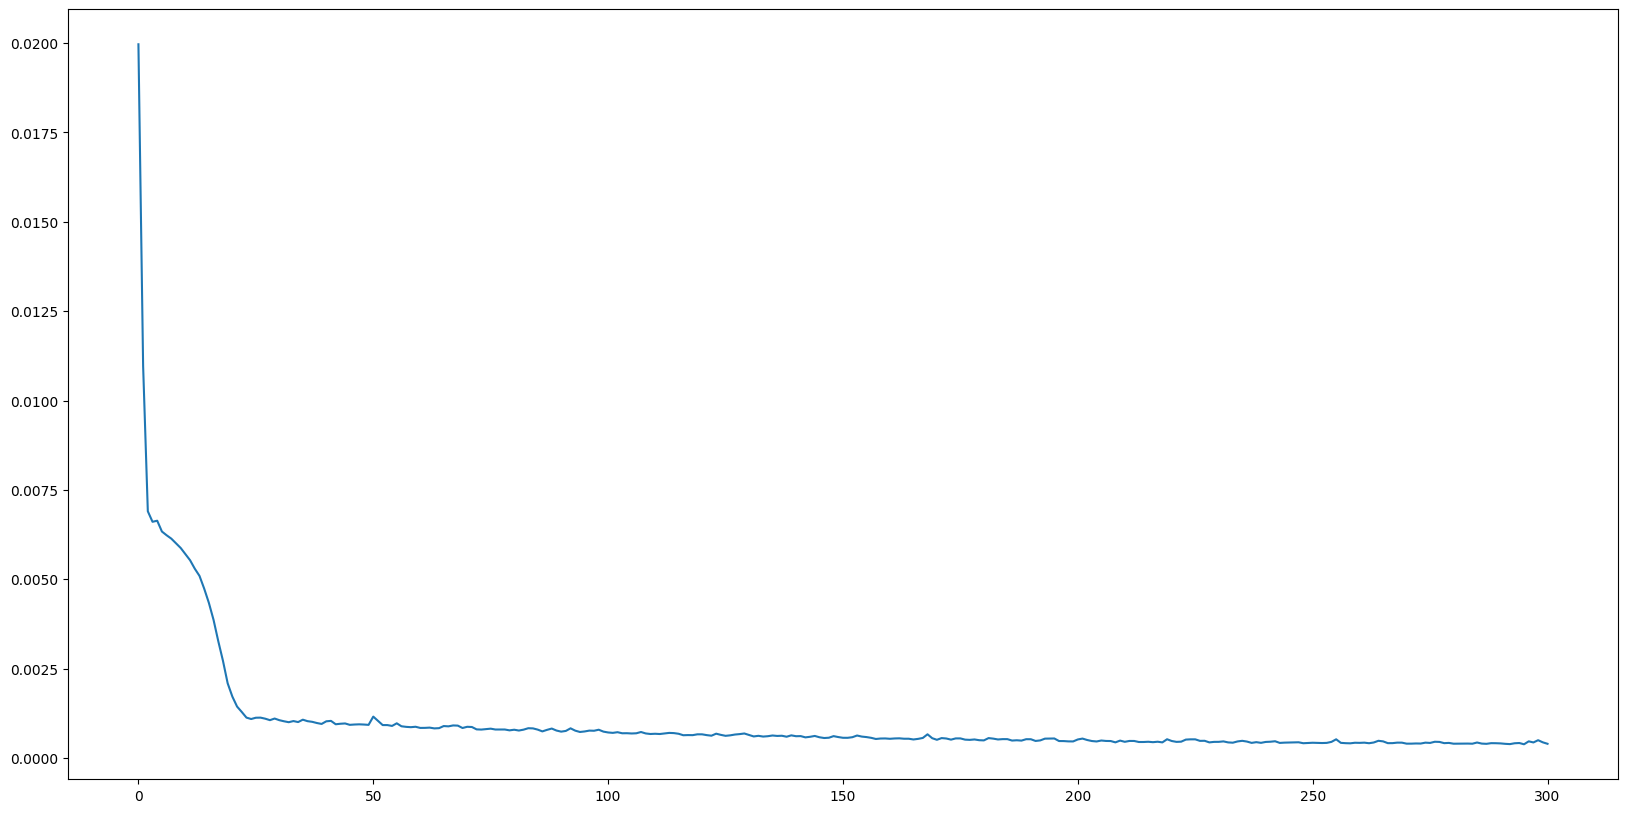

In [30]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 기본 RNN의 문제점
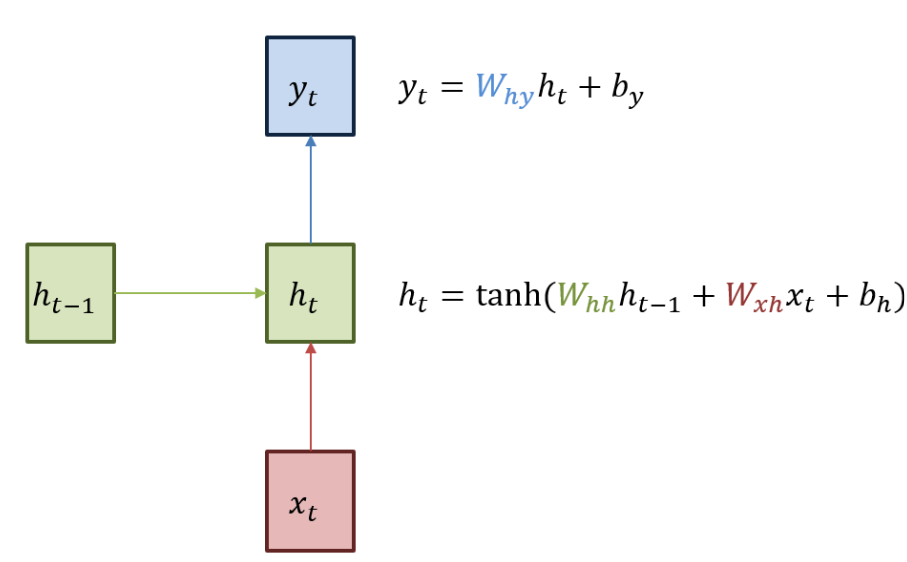
##### 기울기 사라짐
* RNN은 기본적으로 활성화 함수 Tanh를 계산하는 형태다.
* 따라서 역전파를 진행할 때 Tanh의 미분을 수행하는데, 미분값이 0에 가까운 값들이 나오게 되어 적절한 변수를 찾기 어렵다.
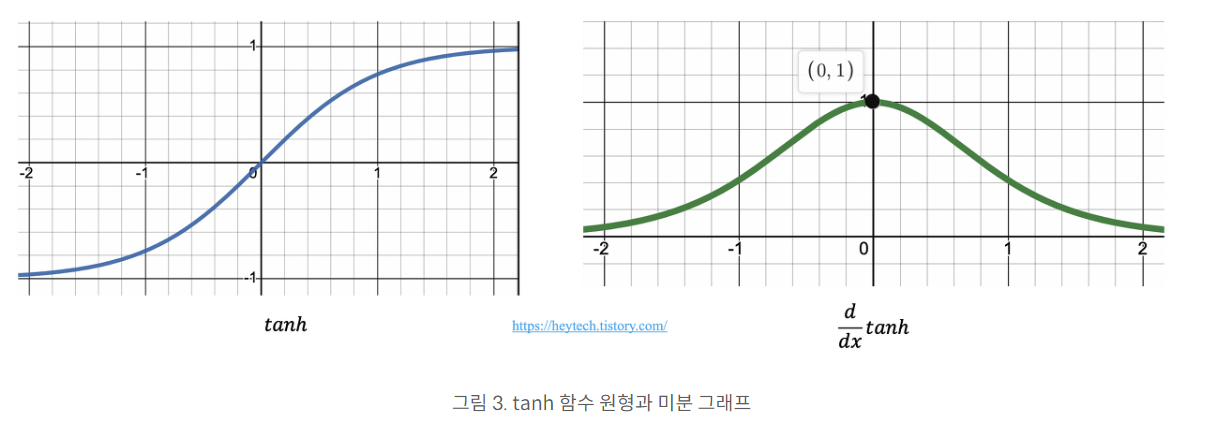

##### 장기 의존성
* RNN의 경우 시퀀스가 너무 길다면 앞 쪽의 타임 스텝의 정보가 후반 타임 스텝까지 충분히 전달되지 못하는 문제가 있다.

### LSTM(Long Short-Term Memory)
* LSTM은 기본 RNN의 단점을 보완하고자 셀 상태 s와 모든 값이 0과 1 사이인 입력 게이트i, 망각 게이트f, 출력 게이트 o를 추가하여 이전 정보와 현재 정보를 비중을 조율하여 예측에 반영되고 그 값이 다음 타임 스텝으로 전달된다.
* 파이토치에서 제공되는 nn.LSTM을 사용하여 내부 계산을 별도로 할 필요가 없다.
* 즉, LSTM의 모델 파라미터인 W와 U들이 자동으로 관리된다.
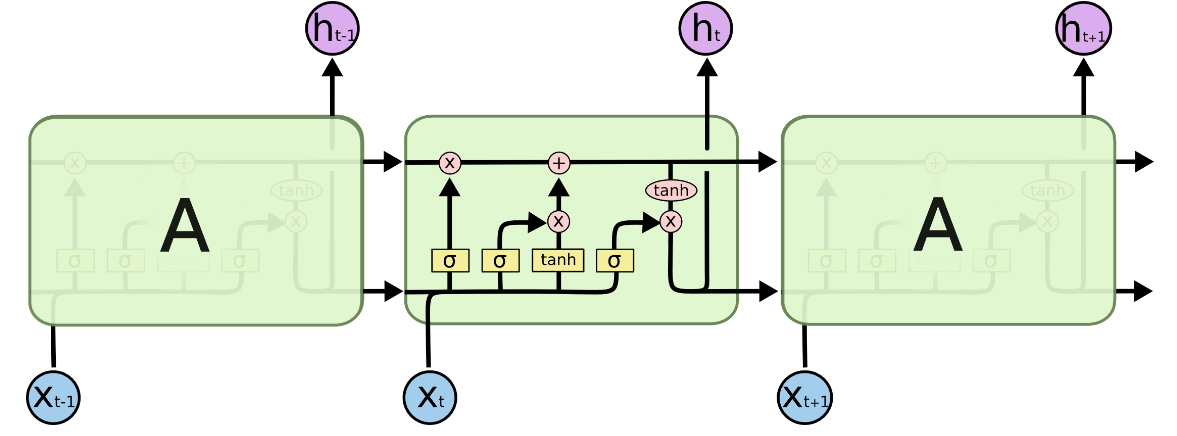

### 모델 구축하기

In [31]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM,self).__init__()
    self.device=device
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True) # nn.LSTM 모듈을 사용하여 LSTM 층을 정의한다.
    self.fc=nn.Linear(hidden_size*sequence_length,1) # 완전 연결 층(Linear layer)을 정의한다. 이 층은 LSTM의 출력을 입력으로 받아 최종 결과를 출력한다.

  def forward(self, x): # forward 메소드는 모델이 학습 데이터를 어떻게 처리할지를 정의한다.
    h0=torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device) # LSTM의 셀 상태를 초기화한다.
    c0=torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device) # LSTM의 셀 상태를 초기화한다.
    out,_=self.lstm(x,(h0,c0)) # LSTM 층을 통과시킨다.
    out=out.reshape(out.shape[0],-1) # 출력 텐서의 형태로 변경한다.
    out=self.fc(out) # 완전 연결 층을 통과시킨다.
    return out

### LSTM 모델 불러오기
* 입력값의 크기, 은닉 상태 크기, 시퀀스 길이, 은닉층 개수, gpu 연산을 위한 device 변수까지 모델에 넣어준다.
* 또한 GPU 연산을 위해 .to(device)를 붙여준다.

In [35]:
model = LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers, device=device)

model = model.to(device)

### 손실 함수 정의 및 학습 최적화

In [36]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=lr)

### 모델 학습하기



In [38]:
loss_graph = []
n = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.6340
[epoch: 100] loss: 0.0010
[epoch: 200] loss: 0.0009
[epoch: 300] loss: 0.0008


### 학습 손실 함수값 그리기
* 손실 함수를 통해 단편적으로 훈련이 잘 됐음을 확인할 수 있다.

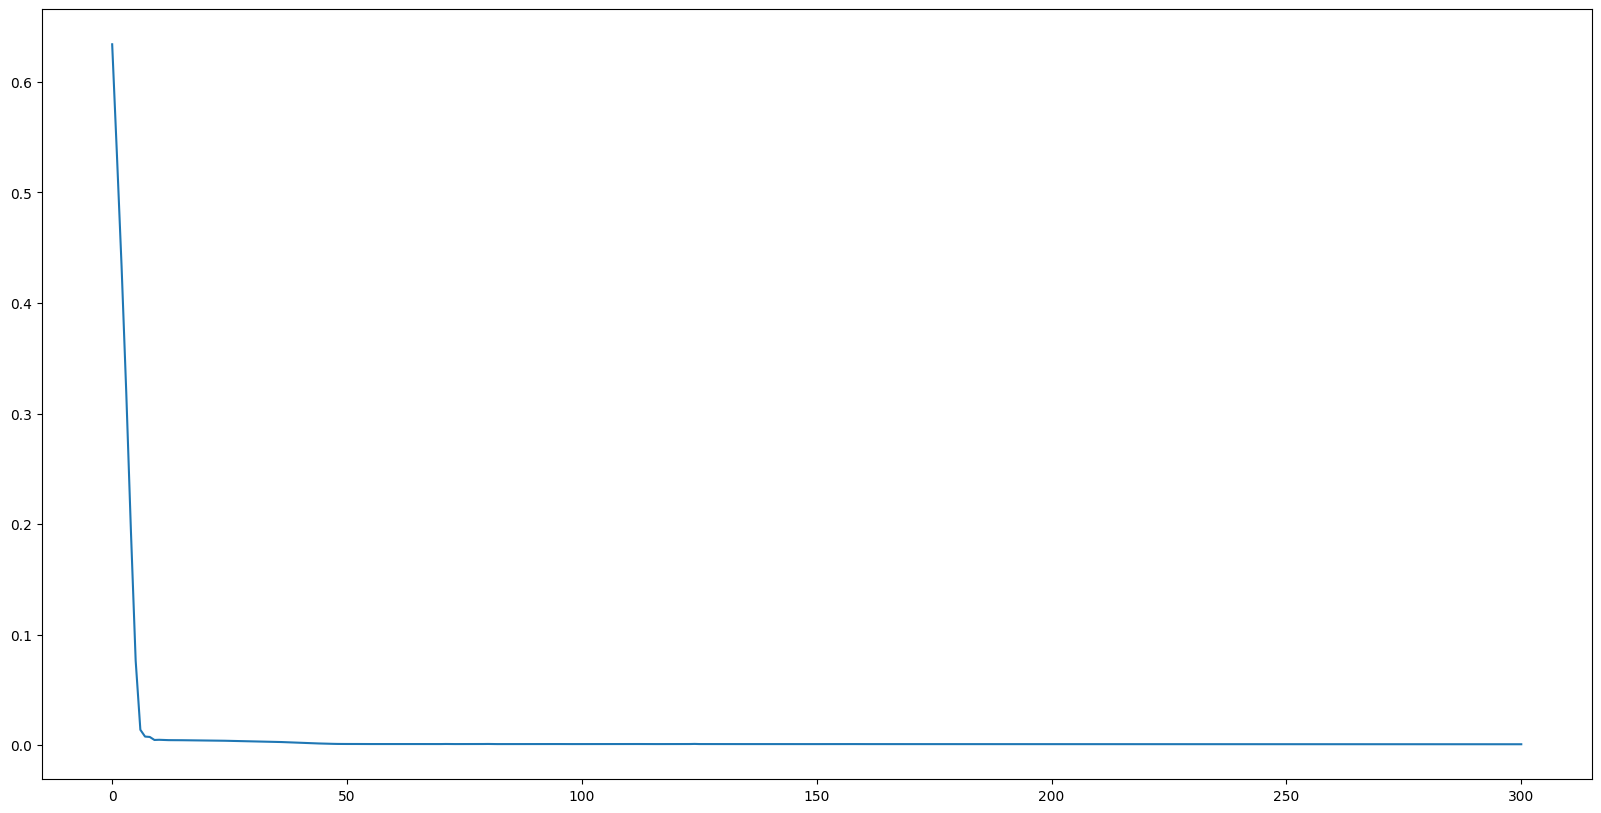

In [39]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

#### LSTM 원리
* LSTM은 hidden state만이 아니라 cell state라는 역할이 있으며 Forget gate, Input gate, Output gate를 통해 계산이 이루어진다.

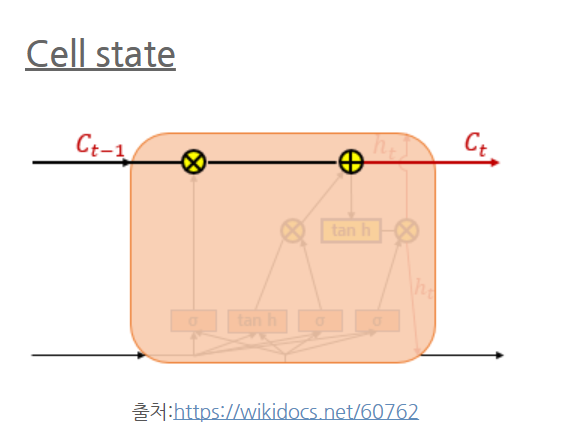

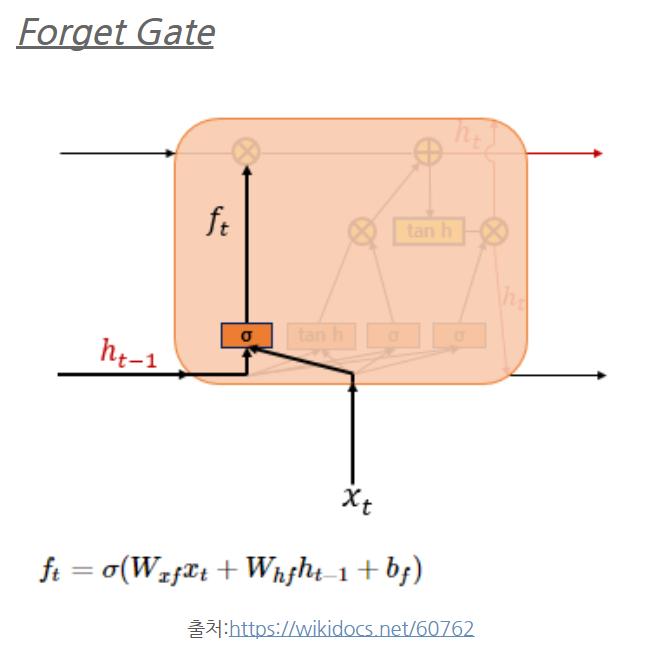

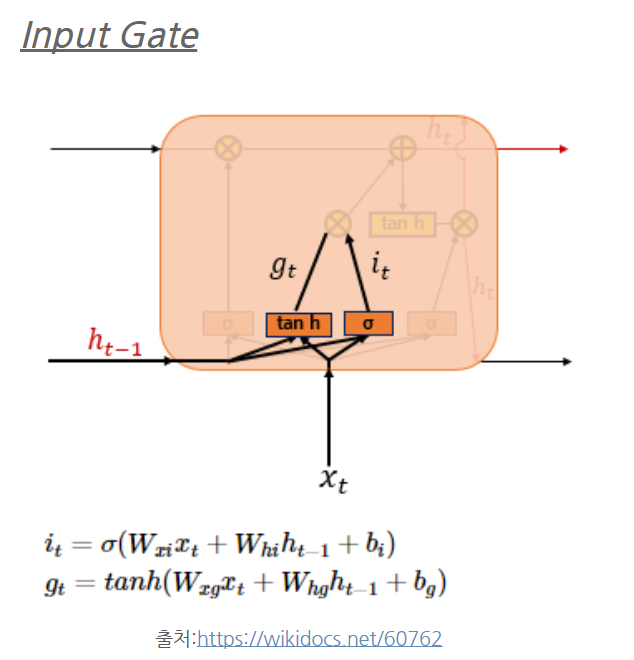

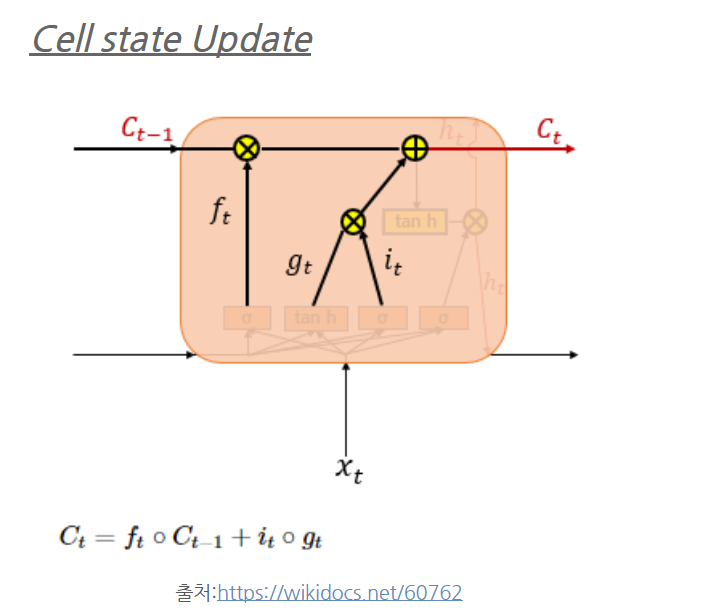

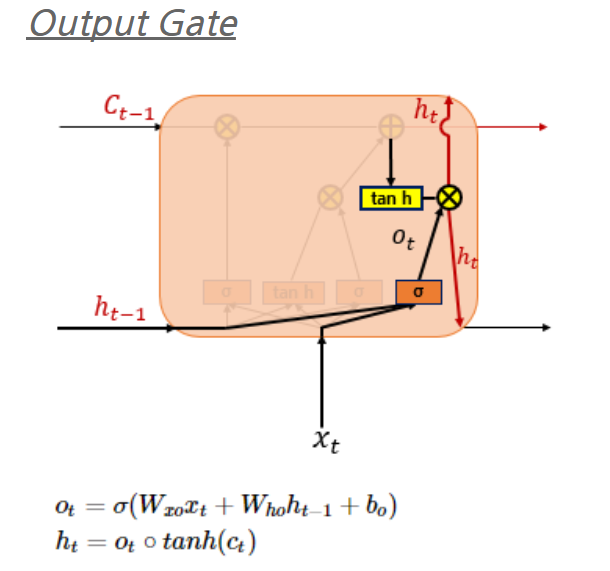


### GRU(Gated Recurrent Units)
* LSTM은 기본 RNN에서 추가로 셀 상태와 3개의 게이트를 사용하기 때문에 속도가 느리다.
* 이를 해결하기 위해 셀 상태를 없애고 2개의 게이트만 사용하여 LSTM을 간소화한 모델이 GRU이다.
* GRU에서는 reset gate, update gate 2개의 gate만을 사용한다.

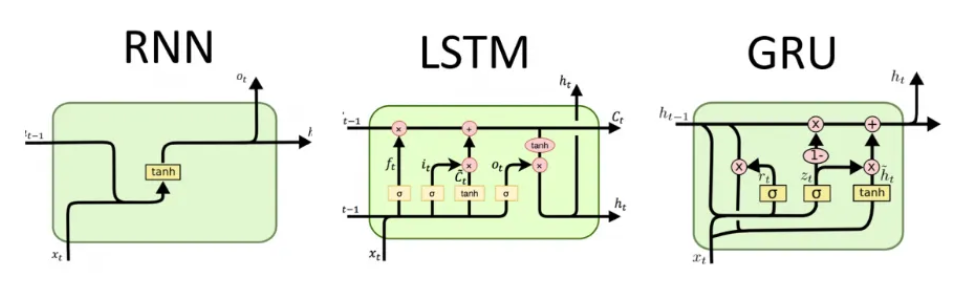

### 모델 구축하기

In [43]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # nn.GRU 모듈을 사용하여 GRU 층을 정의한다.
        self.fc = nn.Linear(hidden_size*sequence_length, 1) # 완전 연결 층(Linear layer)을 정의한다. 이 층은 GRU의 출력을 입력으로 받아 최종 결과를 출력한다.

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # 은닉 상태를 초기화한다.
        out, _ = self.gru(x, h0) # GRU 층을 통과시킨다.
        out = out.reshape(out.shape[0], -1) # 출력 텐서의 형태를 변경한다.
        out = self.fc(out)  # 완전 연결 층을 통과시킨다.
        return out

### GRU 모델 불러오기


In [44]:
model = GRU(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers, device=device)

model = model.to(device)

### 손실 함수 정의 및 학습 최적화

In [45]:
criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=lr)

### 모델 학습하기

In [46]:
loss_graph = []
n = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.1563
[epoch: 100] loss: 0.0010
[epoch: 200] loss: 0.0009
[epoch: 300] loss: 0.0006


### 학습 손실 함수값 그리기
* 손실 함수를 통해 단편적으로 훈련이 잘 됐음을 확인할 수 있다.

In [47]:
loss_graph = []
n = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0006
[epoch: 100] loss: 0.0004
[epoch: 200] loss: 0.0004
[epoch: 300] loss: 0.0004


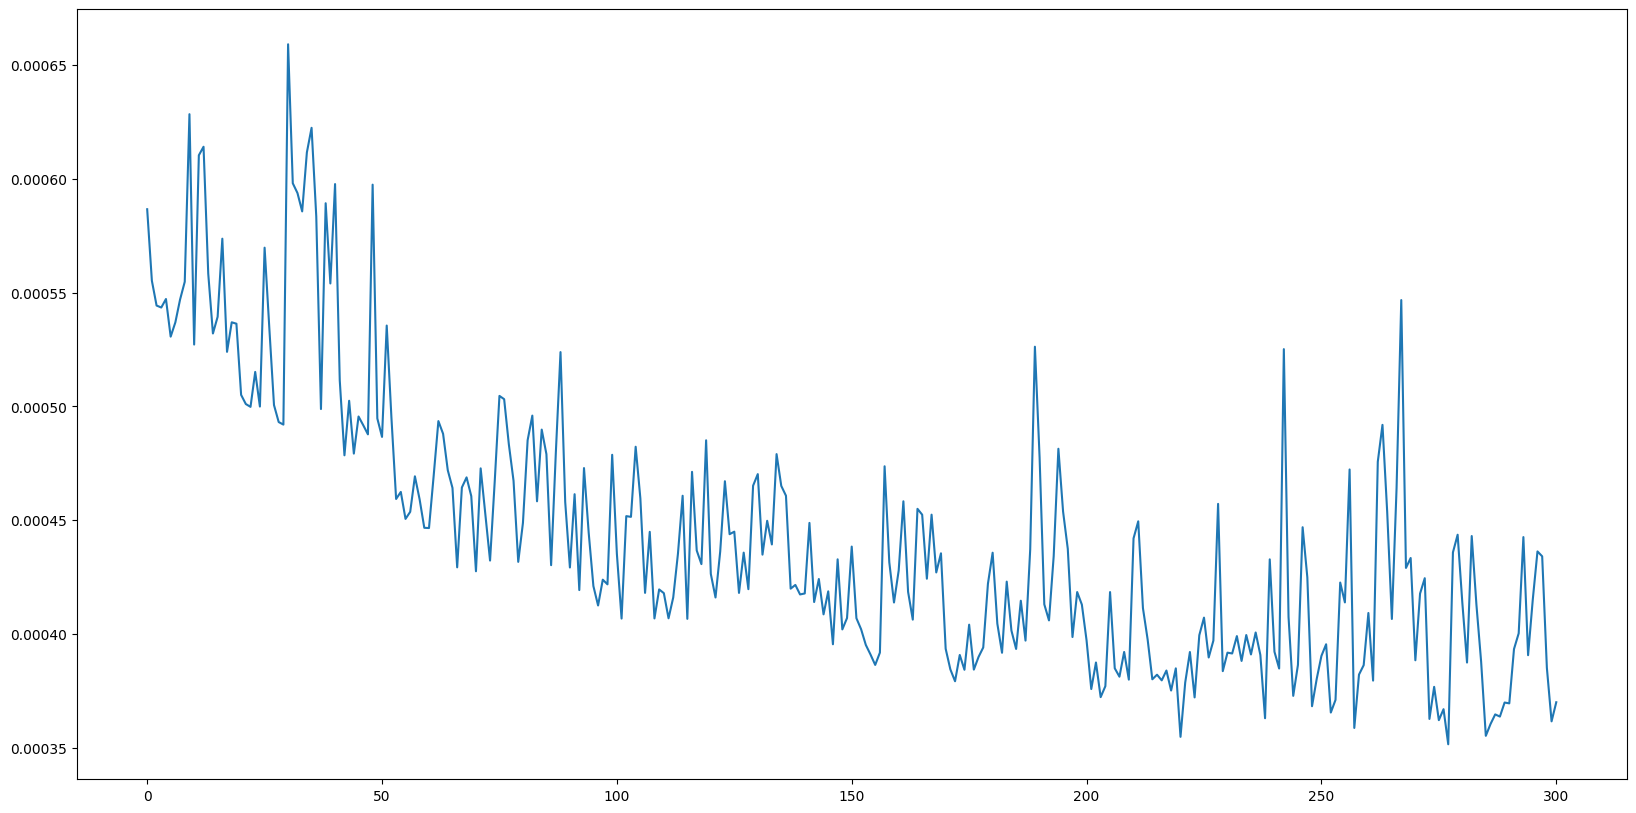

In [48]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()